# Unterpunkt 3: The time-dependent Schrödinger equation
# in one dimension with Crank-Nicolson

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Unterpunkt a: Schrödinger lösen

In [2]:

def schroedinger_cn(Nx, dx, Nt, dt, psi0, V):
    # Schritte nach Angabe
    # Schritt 1: Randbedingungen
    psi = np.zeros((Nt+1, Nx), dtype=complex)
    psi[0] = psi0
    
    # Schritt 2: a_k berechnen
    a = np.zeros(Nx, dtype=complex)
    a[1] = 2 * (1 + dx*dx*V[1] - 1j*2*dx*dx/dt)

    for k in range(2, Nx-1):
        a[k] = 2 * (1 + dx*dx*V[k] - 1j*2*dx*dx/dt) - 1/a[k-1]

    # Schritt 3–7: Zeitentwicklung
    for n in range(Nt):
        # Schritt 4: Ω_k^n
        Omega = np.zeros(Nx, dtype=complex)
        for k in range(1, Nx-1):
            Omega[k] = (
                -psi[n, k-1]
                + 2*(1j*2*dx*dx/dt + 1 + dx*dx*V[k]) * psi[n, k]
                - psi[n, k+1]
            )

        # Schritt 5: b_k^n
        b = np.zeros(Nx, dtype=complex)
        b[1] = Omega[1]
        for k in range(2, Nx-1):
            b[k] = b[k-1]/a[k-1] + Omega[k]

        # Schritt 6: Rückwärtssubstitution
        psi[n+1, 0] = 0
        psi[n+1, -1] = 0
        for k in range(Nx-2, 0, -1):
            psi[n+1, k] = (psi[n+1, k+1] - b[k]) / a[k]

    return psi


### Unterpunkt b: Gauss Packet

In [3]:

def gauss_packet(Nx, dx, sigma, x0, q):
    
    x = np.arange(Nx) * dx
    psi0 = np.exp(-((x - x0)**2) / (2*sigma**2)) * np.exp(1j * q * x)
    psi0[0] = 0
    psi0[-1] = 0
    psi0 /= np.sqrt(np.sum(np.abs(psi0)**2) * dx) # Normierung sonst is propability nicht conserved
    return psi0


Nx = 2000
dx = 0.01
Nt = 2000
dt = 0.001

sigma = 0.5
x0    = 5.0
q     = 10.0

V = np.zeros(Nx)

psi0 = gauss_packet(Nx, dx, sigma, x0, q)

psi = schroedinger_cn(Nx, dx, Nt, dt, psi0, V)


### Unterpunkt c: Plot

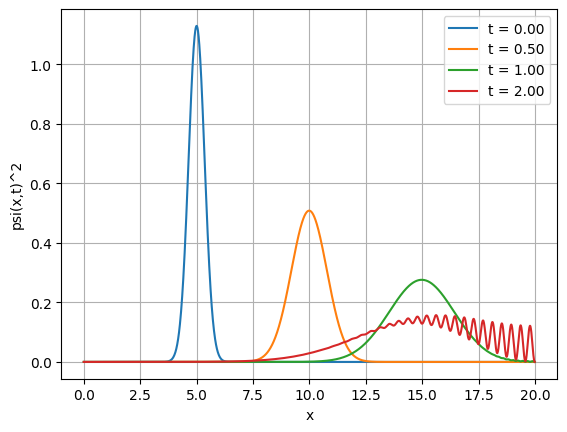

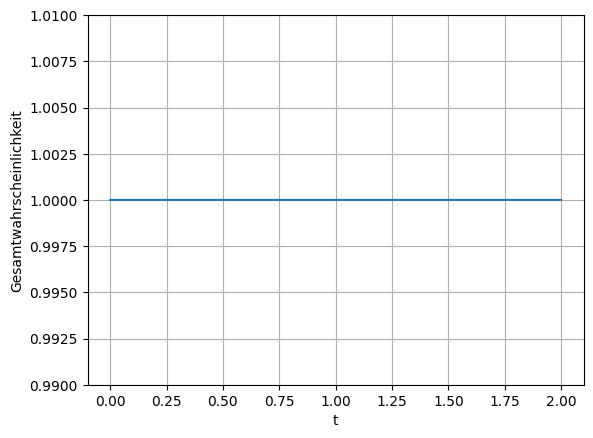

In [4]:

# Raum- und Zeitgitter
x = np.arange(Nx) * dx
t = np.arange(Nt+1) * dt

# Wahrscheinlichkeitsdichte
rho = np.abs(psi)**2

#Plot 1: |psi(x,t)|^2 für vier Snapshots
plt.figure()
for n in [0, Nt//4, Nt//2, Nt]: #Snapshots t=0, t=0.5, t=1.0, t=2.0
    plt.plot(x, rho[n], label=f"t = {t[n]:.2f}")
plt.xlabel("x")
plt.ylabel("psi(x,t)^2")
plt.legend()
plt.grid(True)
plt.show()

#Plot 2: Gesamtwahrscheinlichkeit
norm = np.sum(rho, axis=1) * dx

plt.figure()
plt.plot(t, norm)
plt.xlabel("t")
plt.ylabel("Gesamtwahrscheinlichkeit")
plt.ylim(0.99, 1.01)   
plt.grid(True)
plt.show()





### Unterpunkt d: Potentiale

In [ ]:

sigma = 20.0
q = 2.0
x0 = 0.0

V0_list = [1.5, 2.0, 2.5]
a = 100.0
b = 200.0
dbar = 10.0


dx = 0.1
Nx = int(400.0 / dx) + 1          
x = np.arange(Nx) * dx

dt = 0.01
Nt = int(120/dt)   # 12000
                         


psi0 = (1.0 / np.sqrt(sigma * np.sqrt(np.pi))) * np.exp(-((x - x0)**2) / (2.0 * sigma**2)) * np.exp(1j * q * x)
psi0[0] = 0
psi0[-1] = 0


def make_V1(V0):
    # V1(x) = V0[θ(x-a) - θ(x-(a+d))]
    return V0 * ((x >= a).astype(float) - (x >= (a + dbar)).astype(float))

def make_V2(V0):
    # V2(x) = V1(x) + V0[θ(x-b) - θ(x-(b+d))]
    return make_V1(V0) + V0 * ((x >= b).astype(float) - (x >= (b + dbar)).astype(float))


psi_V1 = {}   
psi_V2 = {}

for V0 in V0_list:
    V1 = make_V1(V0)
    V2 = make_V2(V0)

    psi_V1[V0] = schroedinger_cn(Nx, dx, Nt, dt, psi0, V1)
    psi_V2[V0] = schroedinger_cn(Nx, dx, Nt, dt, psi0, V2)


### Unteerpunkt e: Plots zu Potentialen

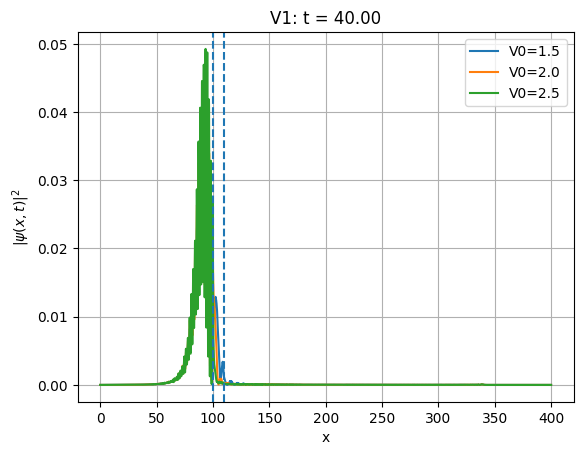

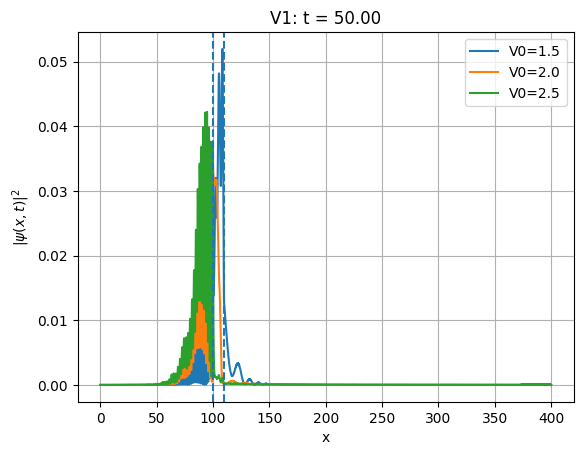

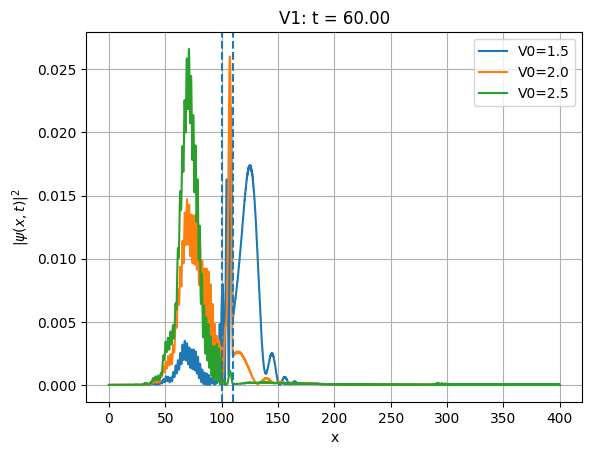

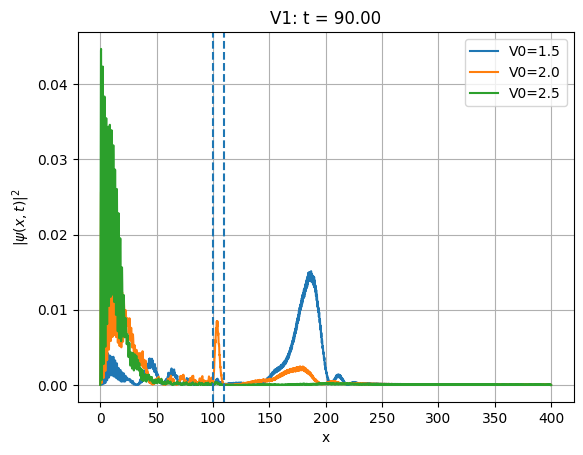

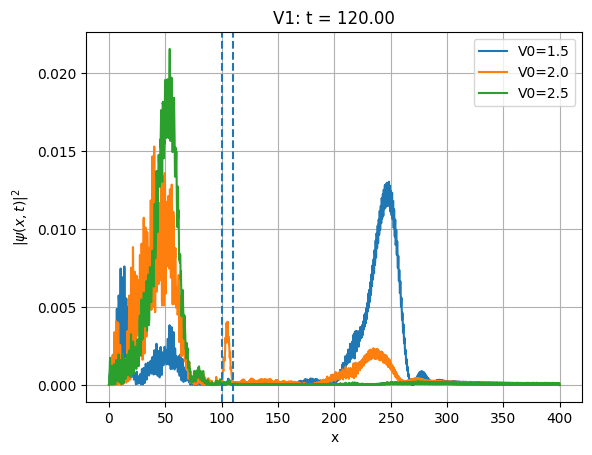

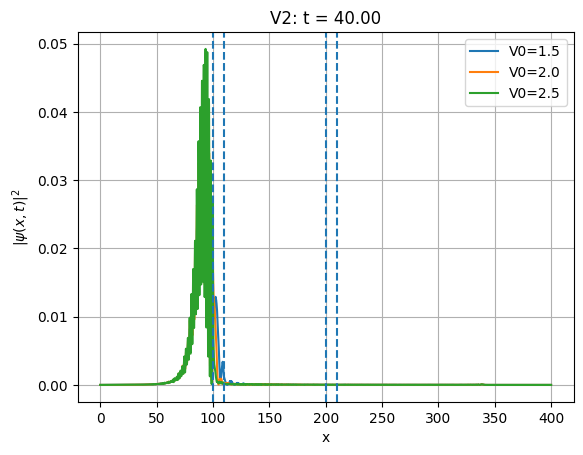

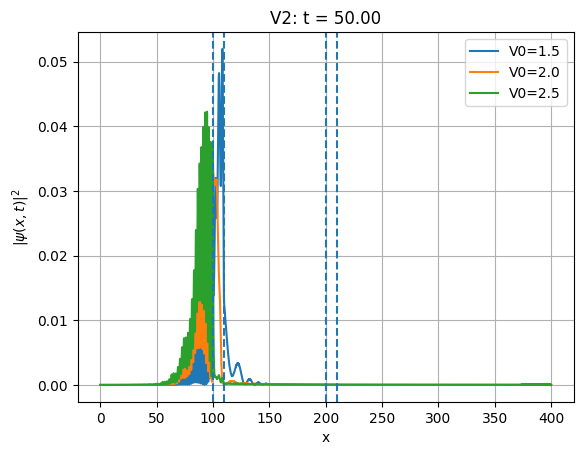

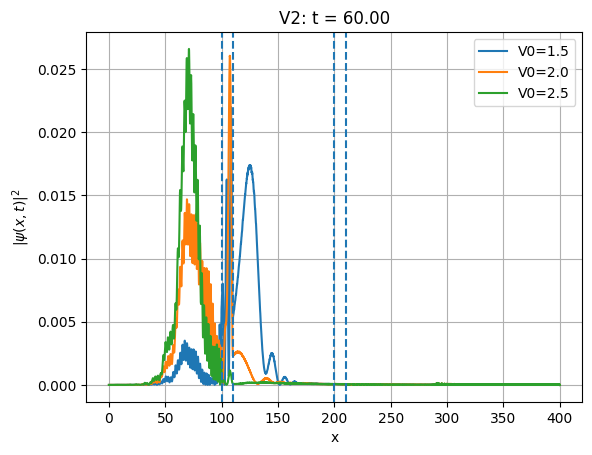

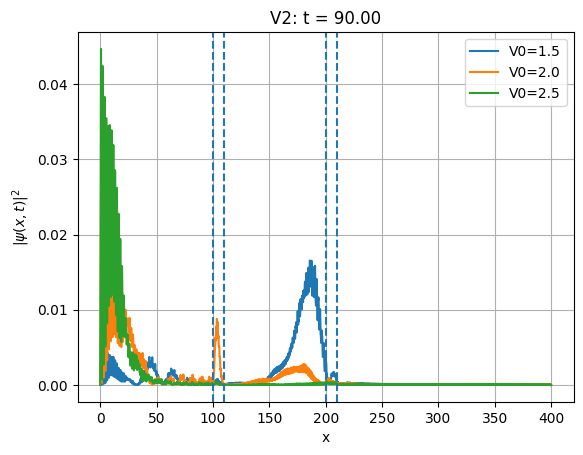

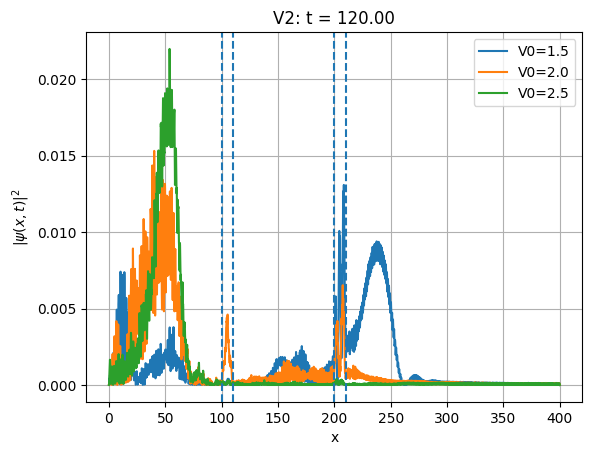

In [ ]:

def pick_times(dt, Nt, v, a, b):
    """Wählt 5 sinnvolle Zeitpunkte (vor/bei/nach Barrieren)."""
    tmax = Nt * dt
    ta = a / v
    tb = b / v

    # Kandidatenzeiten (physikalisch sinnvoll)
    cand = [0.0, 0.6*ta, ta, 1.4*ta, min(tmax, 0.9*tmax)]
    # Wenn zweite Barriere im Zeitfenster liegt, ersetze einen Zeitpunkt durch tb
    if tb < tmax:
        cand[3] = tb  # ersetze "1.4*ta" durch Zeitpunkt zweite Barriere

    # clamp in [0, tmax]
    cand = [min(max(0.0, tc), tmax) for tc in cand]

    # zu Indizes runden
    idx = [int(round(tc / dt)) for tc in cand]
    idx = [min(max(0, i), Nt) for i in idx]
    return idx

def plot_snapshots(psi_dict, title_prefix, x, dt, idx_list, V0_list, a, b, dbar):
    for idx in idx_list:
        plt.figure()
        for V0 in V0_list:
            rho = np.abs(psi_dict[V0][idx])**2
            plt.plot(x, rho, label=f"V0={V0}")

        # Barrieren markieren (nur Linien, minimal)
        plt.axvline(a, linestyle="--")
        plt.axvline(a + dbar, linestyle="--")
        if title_prefix.endswith("V2"):
            plt.axvline(b, linestyle="--")
            plt.axvline(b + dbar, linestyle="--")

        plt.xlabel("x")
        plt.ylabel(r"$|\psi(x,t)|^2$")
        plt.title(f"{title_prefix}: t = {idx*dt:.2f}")
        plt.grid(True)
        plt.legend()
        plt.show()

# Gruppengeschwindigkeit v = q/m, hier m=1
v = q  # da m=1

times = [40, 50, 60, 90, 120]
idx_list = [int(tt/dt) for tt in times]



plot_snapshots(psi_V1, "V1", x, dt, idx_list, V0_list, a, b, dbar)
plot_snapshots(psi_V2, "V2", x, dt, idx_list, V0_list, a, b, dbar)
